**2D nonlinear diffusion-reaction system**

In [494]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 10
batch_size = 500
noise_scale = 0.01
num_samples = 1000
num_sensors = 32

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})
sns.set_style("whitegrid")

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 1
        self.numParams = 1
        self.numOutputs = 2
        self.hidden_size = 50

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = torch.zeros((batch_size,self.numParams), requires_grad=True, device=self.device)
        self.mean_predicted_params = torch.zeros((self.numParams), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)
        self.act = nn.Tanh()


    def create_dataset(self, noise_scale=0.01, num_samples=16):
        
        # Generate x and y points evenly spaced between -1 and 1
        x1 = torch.linspace(-0.8, -0.2, num_samples, device=self.device)  
        x2 = torch.linspace(0.2, 0.8, num_samples, device=self.device)

        self.sensor_x = torch.cat([x1, x2]).requires_grad_(True)
        # self.sensor_x = torch.linspace(-1, 1, num_samples, device=self.device).requires_grad_(True)
        self.sensor_u = exact_solution(self.sensor_x) + torch.randn(self.sensor_x.shape[0], device=self.device) * noise_scale


    def forward(self, x):
        # if not torch.is_tensor(x):
        #     x = torch.from_numpy(x).float().to(self.device)


        # Add a dimension if it's not already there
        x = x.unsqueeze(1) if x.dim() == 1 else x


        h1 = self.act(self.b1(x))
        h2 = self.act(self.b2(h1))

        prior_param_samples = torch.rand(x.shape[0], self.hidden_size, device=self.device).requires_grad_(True)
        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples, t2 = self.sample_parameter_posterior(prior_param_samples)
        self.update_predicted_params(posterior_samples)
        u = self.b3(torch.multiply(t2, h2))
        # u = self.b3(h2)

        return u[:,0], u[:,1]


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)


    def PDE_residual(self, x):
        u, log_var = self.forward(x)
        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        residual = u - torch.pow(torch.sin(self.predicted_params * x), 3)
        # residual = u - torch.pow(torch.sin(self.predicted_params * x), 3)
        return residual,log_var


    
    def loss_interior(self, num_samples=500):
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res1,log_var = self.PDE_residual(interior_x_samples)
        # loss_residual1 = torch.mean(torch.square(res1))
        loss_residual1 = ngll(res1, torch.zeros_like(res1), torch.exp(log_var))
        return loss_residual1 


    def loss_data(self):
        u_pred, log_var = self.forward(self.sensor_x)
        # error = torch.square(u_pred.squeeze() - self.sensor_u)
        # loss_u = torch.mean(error)
        loss_u = ngll(u_pred, self.sensor_u, torch.exp(log_var))
        return loss_u

    def compute_losses(self):
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        return loss_interior, loss_data


    def sample_parameter_posterior(self, prior):
        
        t1 = self.act(self.t1(prior))
        t2 = self.act(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples, t2 


    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data = self.compute_losses()
        total_loss = self.w_int * loss_interior \
                    + self.w_data * loss_data 




        # Add the (Log(std))**2 term to the loss with the specified weight
        # Add the (Log(w * std))**2 term to the loss with the specified weight
        # self.log_std_squared_loss = torch.mean(torch.log(self.w_param_std * self.std_params)**2)
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        # total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)

        
        return total_loss


    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=10, verbose=True)


        # Training loop
#         for epoch in range(epochs):
        for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
            self.optimizer.step(self.closure)
            if epoch % 200 == 0:
                loss_interior, loss_data = self.compute_losses()
                
                total_loss =  loss_data  

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():g}  ' \
                        f'PDE Loss:{loss_interior.item():.4f}  ' \
                        f'Data Loss: {loss_data.item():.4f}  ' \
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.4f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.4f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.4f}')

In [495]:
ngll = torch.nn.GaussianNLLLoss()

In [496]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [497]:
# exact solution
def exact_solution(x, param = 6.0):
    return torch.pow(torch.sin(param * x),3)

In [498]:
def make_plot(model, device=device):
    # Generate test data
    num_test_samples = 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device).unsqueeze(1)
    

    model.eval()
    with torch.no_grad():
        u_preds, log_vars = model.forward(x_test)
  
    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_test)

    # Create plots
    

    fig, ax = plt.subplots()

    
    # Plot predicted 'u'
    ax.plot(x_test.cpu().numpy(),u_preds.cpu().numpy(), label='Predicted')
    # Plot exact 'u'
    ax.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
    ax.plot(model.sensor_x.cpu().detach().numpy(), model.sensor_u.cpu().detach().numpy(), 'o', alpha=0.5, label='Data')


    plt.tight_layout()
    # plt.savefig('result_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.legend()
    plt.show()
    return ax

In [499]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

mps
Params: 7903


In [500]:
net.create_dataset(num_samples=32)

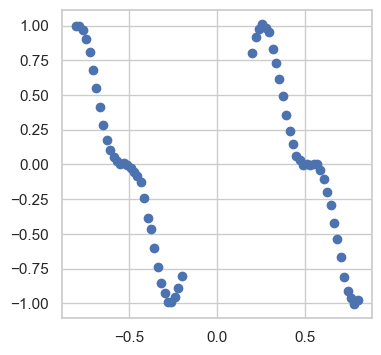

In [501]:
plt.plot(net.sensor_x.cpu().detach().numpy(), net.sensor_u.cpu().detach().numpy(), 'o')

In [555]:
net.w_int = 200
net.w_data = 5000
net.w_bc   = 0
net.w_param_std = 10

In [556]:
# net.w_int = 2000
# net.w_data = 1000
# net.w_bc   = 0
# net.w_param_std = 1

In [568]:
torch.autograd.set_detect_anomaly(True)
net.train(35000, optimizer='Adam', lr=5e-3)

Training Progress:   0%|          | 5/35000 [00:00<30:43, 18.98epoch/s]

Epoch(Adam):0,  Total Loss:32.9033  PDE Loss:32.0449  Data Loss: 32.9033  Mean Predicted Param 1: -0.1859 Std Params:0.0018  Std Log Loss:406.1282


Training Progress:   1%|          | 203/35000 [00:09<26:12, 22.13epoch/s]

Epoch(Adam):200,  Total Loss:-1.99192  PDE Loss:7.4954  Data Loss: -1.9919  Mean Predicted Param 1: -0.4007 Std Params:0.0020  Std Log Loss:401.0697


Training Progress:   1%|          | 404/35000 [00:17<25:42, 22.42epoch/s]

Epoch(Adam):400,  Total Loss:-2.2254  PDE Loss:7.7776  Data Loss: -2.2254  Mean Predicted Param 1: -0.3776 Std Params:0.0020  Std Log Loss:389.0113


Training Progress:   2%|▏         | 605/35000 [00:26<25:31, 22.46epoch/s]

Epoch(Adam):600,  Total Loss:-2.26079  PDE Loss:8.9321  Data Loss: -2.2608  Mean Predicted Param 1: -0.3564 Std Params:0.0016  Std Log Loss:419.9705


Training Progress:   2%|▏         | 803/35000 [00:35<26:25, 21.56epoch/s]

Epoch(Adam):800,  Total Loss:-2.307  PDE Loss:9.3440  Data Loss: -2.3070  Mean Predicted Param 1: -0.3592 Std Params:0.0016  Std Log Loss:396.6036


Training Progress:   3%|▎         | 1004/35000 [00:44<25:24, 22.29epoch/s]

Epoch(Adam):1000,  Total Loss:-2.26978  PDE Loss:9.5140  Data Loss: -2.2698  Mean Predicted Param 1: -0.3760 Std Params:0.0014  Std Log Loss:420.9374


Training Progress:   3%|▎         | 1205/35000 [00:53<25:20, 22.23epoch/s]

Epoch(Adam):1200,  Total Loss:-2.3447  PDE Loss:9.8249  Data Loss: -2.3447  Mean Predicted Param 1: -0.2008 Std Params:0.0017  Std Log Loss:407.2095


Training Progress:   4%|▍         | 1403/35000 [01:02<25:25, 22.03epoch/s]

Epoch(Adam):1400,  Total Loss:-2.38917  PDE Loss:9.4972  Data Loss: -2.3892  Mean Predicted Param 1: -0.1379 Std Params:0.0016  Std Log Loss:422.9486


Training Progress:   5%|▍         | 1604/35000 [01:11<24:43, 22.51epoch/s]

Epoch(Adam):1600,  Total Loss:-2.44581  PDE Loss:9.1119  Data Loss: -2.4458  Mean Predicted Param 1: -0.1062 Std Params:0.0015  Std Log Loss:434.1208


Training Progress:   5%|▌         | 1805/35000 [01:20<25:16, 21.89epoch/s]

Epoch(Adam):1800,  Total Loss:-2.46266  PDE Loss:12.8963  Data Loss: -2.4627  Mean Predicted Param 1: -0.1257 Std Params:0.0013  Std Log Loss:424.5574


Training Progress:   6%|▌         | 2003/35000 [01:28<24:56, 22.05epoch/s]

Epoch(Adam):2000,  Total Loss:-2.43745  PDE Loss:9.8936  Data Loss: -2.4374  Mean Predicted Param 1: -0.1522 Std Params:0.0010  Std Log Loss:492.7281


Training Progress:   6%|▋         | 2204/35000 [01:37<25:01, 21.84epoch/s]

Epoch(Adam):2200,  Total Loss:-2.46033  PDE Loss:10.5915  Data Loss: -2.4603  Mean Predicted Param 1: -0.1382 Std Params:0.0008  Std Log Loss:511.8687


Training Progress:   7%|▋         | 2405/35000 [01:46<24:29, 22.18epoch/s]

Epoch(Adam):2400,  Total Loss:-2.4821  PDE Loss:10.7004  Data Loss: -2.4821  Mean Predicted Param 1: -0.1423 Std Params:0.0007  Std Log Loss:541.4975


Training Progress:   7%|▋         | 2603/35000 [01:55<23:17, 23.19epoch/s]

Epoch(Adam):2600,  Total Loss:-2.46104  PDE Loss:10.6931  Data Loss: -2.4610  Mean Predicted Param 1: -0.0848 Std Params:0.0007  Std Log Loss:510.4010


Training Progress:   8%|▊         | 2804/35000 [02:04<24:00, 22.36epoch/s]

Epoch(Adam):2800,  Total Loss:-2.45688  PDE Loss:9.0732  Data Loss: -2.4569  Mean Predicted Param 1: -0.1553 Std Params:0.0007  Std Log Loss:546.5991


Training Progress:   9%|▊         | 3005/35000 [02:13<24:50, 21.46epoch/s]

Epoch(Adam):3000,  Total Loss:-2.49542  PDE Loss:10.6898  Data Loss: -2.4954  Mean Predicted Param 1: -0.1361 Std Params:0.0006  Std Log Loss:550.3400


Training Progress:   9%|▉         | 3203/35000 [02:21<23:55, 22.15epoch/s]

Epoch(Adam):3200,  Total Loss:-2.43612  PDE Loss:9.4400  Data Loss: -2.4361  Mean Predicted Param 1: -0.1502 Std Params:0.0005  Std Log Loss:593.1049


Training Progress:  10%|▉         | 3404/35000 [02:30<23:46, 22.15epoch/s]

Epoch(Adam):3400,  Total Loss:-2.44079  PDE Loss:10.6082  Data Loss: -2.4408  Mean Predicted Param 1: -0.1216 Std Params:0.0004  Std Log Loss:593.9030


Training Progress:  10%|█         | 3605/35000 [02:39<23:17, 22.46epoch/s]

Epoch(Adam):3600,  Total Loss:-2.51579  PDE Loss:10.8039  Data Loss: -2.5158  Mean Predicted Param 1: -0.1243 Std Params:0.0004  Std Log Loss:617.9772


Training Progress:  11%|█         | 3803/35000 [02:48<23:32, 22.09epoch/s]

Epoch(Adam):3800,  Total Loss:-2.46111  PDE Loss:10.2304  Data Loss: -2.4611  Mean Predicted Param 1: -0.1382 Std Params:0.0003  Std Log Loss:633.2653


Training Progress:  11%|█▏        | 4004/35000 [02:57<23:20, 22.14epoch/s]

Epoch(Adam):4000,  Total Loss:-2.46061  PDE Loss:9.6842  Data Loss: -2.4606  Mean Predicted Param 1: -0.1283 Std Params:0.0003  Std Log Loss:694.0449


Training Progress:  12%|█▏        | 4205/35000 [03:06<23:01, 22.29epoch/s]

Epoch(Adam):4200,  Total Loss:-2.44122  PDE Loss:8.0940  Data Loss: -2.4412  Mean Predicted Param 1: -0.1407 Std Params:0.0002  Std Log Loss:682.8229


Training Progress:  13%|█▎        | 4403/35000 [03:15<23:10, 22.00epoch/s]

Epoch(Adam):4400,  Total Loss:-2.45721  PDE Loss:8.9363  Data Loss: -2.4572  Mean Predicted Param 1: -0.0189 Std Params:0.0003  Std Log Loss:699.9192


Training Progress:  13%|█▎        | 4604/35000 [03:23<22:46, 22.24epoch/s]

Epoch(Adam):4600,  Total Loss:-2.5061  PDE Loss:11.3586  Data Loss: -2.5061  Mean Predicted Param 1: 0.0418 Std Params:0.0003  Std Log Loss:687.2320


Training Progress:  13%|█▎        | 4721/35000 [03:29<22:22, 22.56epoch/s]


KeyboardInterrupt: 

In [544]:
predicted_samples = net.predicted_params.clone()

Training Progress: 0epoch [00:00, ?epoch/s]


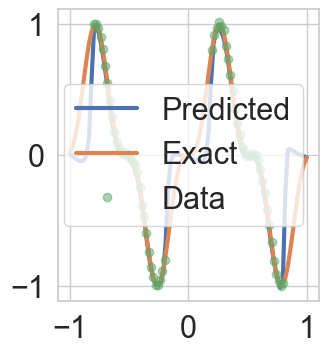

In [569]:
ax = make_plot(net, device=net.device)

In [570]:
def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.tight_layout()
    plt.savefig('2d_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()


def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('2d_log_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

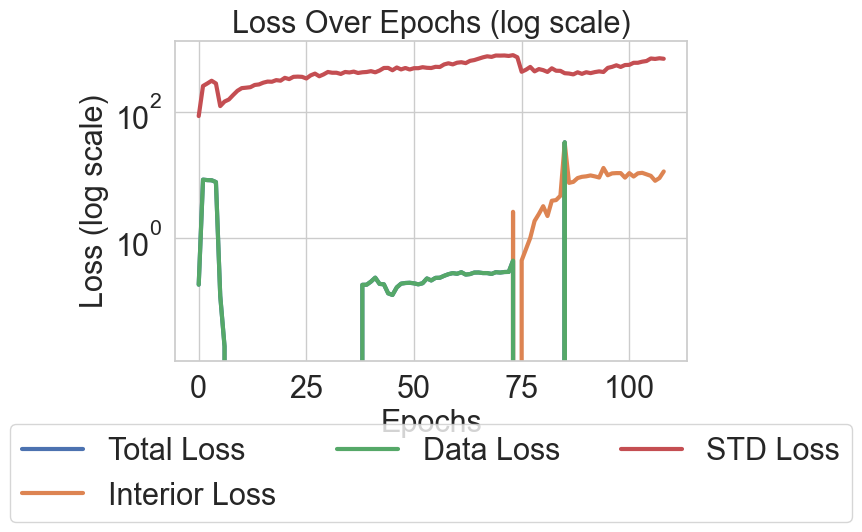

In [571]:
plot_loss_history_log(net)

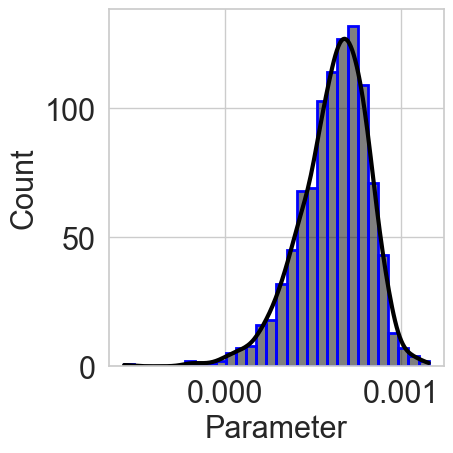

In [572]:
prior = torch.rand(1000, net.hidden_size, device=net.device).requires_grad_(True)
samples, _  = net.sample_parameter_posterior(prior)
samples = samples.detach().cpu().numpy()
df = pd.DataFrame(samples, columns=['Parameter'])

plt.figure(figsize=(5, 5))  # Adjust size as needed for a single plot
sns.histplot(df['Parameter'], kde=True, linewidth=2, edgecolor='blue',
             color='black', bins =30 )
# plt.title('Parameter Distribution')

plt.tight_layout()
plt.savefig('sin_dist_small_noise.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
plt.show()

**Testing the residual plot for the whole batch of data**

In [573]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(samples)
print(gm.means_)

[[0.0006175 ]
 [0.00061799]]


In [574]:
samples.mean()

0.0006178212

In [575]:
def forward_fixed_param(self,x, params):
        
        x = x.unsqueeze(1) if x.dim() == 1 else x


        h1 = self.act(self.b1(x))
        h2 = self.act(self.b2(h1))

        prior_param_samples = torch.rand(x.shape[0], self.hidden_size, device=self.device).requires_grad_(True)
        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples, t2 = self.sample_parameter_posterior(prior_param_samples)
        self.update_predicted_params(posterior_samples)
        u = self.b3(torch.multiply(t2, h2))

        return u[:,0], u[:,1]

In [576]:
plt.rcParams.update({
    'lines.linewidth': 3,      # Default line width for plots
    'font.size': 22,           # Minimum font size for all text elements
    'axes.titlesize': 22,      # Title font size
    'axes.labelsize': 22,      # Axis label font size
    'xtick.labelsize': 22,     # X-axis tick label font size
    'ytick.labelsize': 22,     # Y-axis tick label font size
    'legend.fontsize': 22,     # Legend font size
})

In [577]:
def plot_uncertainty(model, device=device):
    # Generate test data
    num_test_samples = 1000
    num_tests= 10
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
   

    x_flat = x_test.reshape(-1)

    u_preds = []
    vars = []

    model.eval()
    with torch.no_grad():
        for i in range(num_tests):


            # Slice the batch
            x_batch = x_flat
   

            # Predict for this batch
            u_pred, log_vars = forward_fixed_param(model, x_batch, 6.0)

            # Collect predictions
            u_preds.append(u_pred)
            vars.append(log_vars.exp())
    

    # Concatenate all batched predictions
    u_preds = torch.stack(u_preds)
    u_mean = u_preds.mean(dim=0)
    u_std = u_preds.std(dim=0)
    vars = torch.stack(vars)
    vars_mean = vars.mean(dim=0)
    std = 1*vars_mean.sqrt() + 1*u_std



    # Reshape predictions to match the grid shap

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_test)


    # Compute error
    u_error = torch.abs(u_mean - u_exact)

    # Plotting
    fig, axes = plt.subplots(1, 1, figsize=(9 , 5))
    axes.plot(x_test.cpu().numpy(), u_mean.cpu().numpy(), label='Predicted')
    axes.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
    axes.fill_between(x_flat.cpu().numpy(), (u_mean - std).cpu().numpy().flatten(),
                       (u_mean + std).cpu().numpy().flatten(), alpha=0.5, label='Uncertainty')
    axes.scatter(model.sensor_x.cpu().detach().numpy(), model.sensor_u.cpu().detach().numpy(), color='black', label='Data')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))



    

Training Progress: 0epoch [00:00, ?epoch/s]


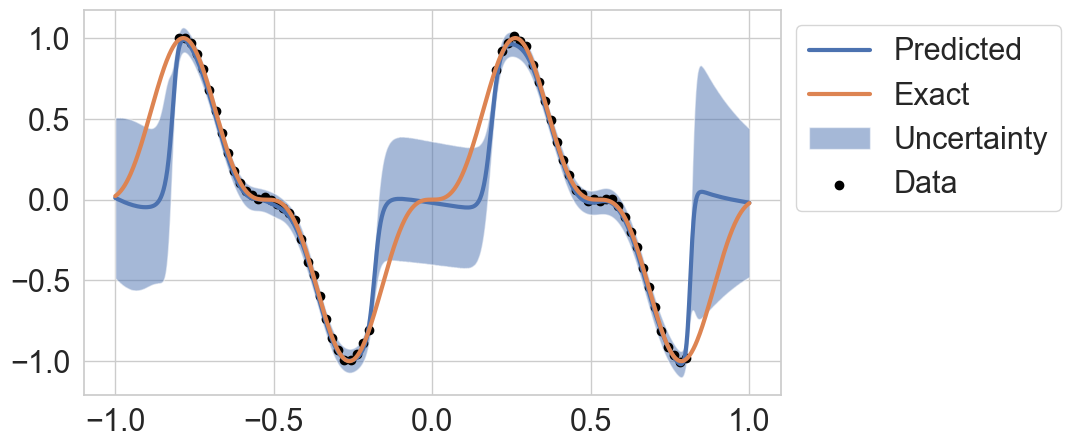

In [579]:
plot_uncertainty(net)
plt.savefig('sin_uncertainty_tmp.png', dpi=400)  # Save the figure as a PNG file with 400 DPI

In [374]:
# plot_posterior_mean_errors(net)

In [580]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_sin_approx-tmp.pth')

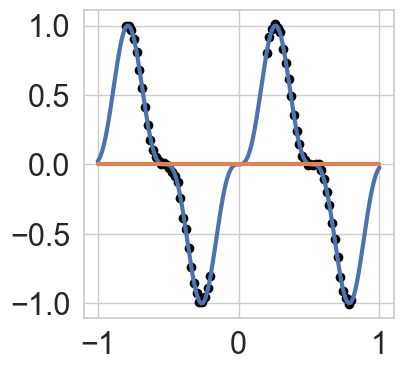

In [420]:
x_test = torch.linspace(-1, 1, 1000, device=device).unsqueeze(1)
plt.plot(x_test.cpu().numpy(), exact_solution(x_test, param=6.0).cpu().numpy())
plt.plot(x_test.cpu().numpy(), exact_solution(x_test, param=0.0).cpu().numpy())
plt.scatter(net.sensor_x.cpu().detach().numpy(), net.sensor_u.cpu().detach().numpy(), color='black')


In [586]:
res_test, _ = net.PDE_residual(x_test)

In [588]:
res_test.shape

torch.Size([1000, 1000])